## MasterProject SoSe22: "Non-Intrusive Load Monitoring" (NILM)

### Related Work and Backgrounds

- Use publicly available data sets **RAE**, as described by [Makonin et al., 2019] in their paper "RAE: The Rainforest Automation Energy Dataset for Smart Grid Meter Data Analysis".
- Follow general NILM problem description, outlined by [Marwah and Han, 2011] in their paper "Unsupervised Disaggregation of Low Frequency Power Measurements".
- A nice overview of various state-of-the-art techniques used for NILM is found in [Herrero et al., 2018] paper "Non Intrusive Load Monitoring (NILM):A State of the Art", including LSTM models.
- [Herrero et al., 2018] references a PhD Thesis [Kelly, 2017] on "Disaggregation of domestic smart meter energy data": Find in Section 9.4.3 a detailed description of a CNN model.

### Game Plan

#### Data

Decided to work on **RAE data set**. That provides total power consumption and submeter data for two houses. Pick the **first house** in this work and find **24 submeters** and **two sampling periods** of 9 and 63 days, respectively. **Sampling rate is 1Hz**. 

**Idea:** Could use 63 days sample for training before testing the model on the second sample covering 9 days.

#### Problem Statement

Given an aggregate power consumption $Y$ for a total of $T$ time periods:

$$Y = (y_1, y_2,..,y_T)$$

We then want to infer the power load of each of the $M$ appliances for all time steps:

$$ Q^{(1)} = (q^{(1)}_1, q^{(1)}_2,..,q^{(1)}_T) \\
   Q^{(2)} = (q^{(2)}_1, q^{(2)}_2,..,q^{(2)}_T) \\
   ... \\
   Q^{(M)} = (q^{(M)}_1, q^{(M)}_2,..,q^{(M)}_T)
$$

#### Model

There exist various approaches for dissagregation of total power consumption. Here we focus on **deep ANN models** from the domain of **supervised machine learning** techniques. The idea is as follows:

- Feed a sample consisting of a number of time steps of the total power consumption time series as input.
- We use a **sliding window approach** and the appropriate **input length** needs to be specified.
- Later we could extend the model and feed time of the day and/or day of the week as **additional input features**.
- As **target** we have **three scalar values** for each of the $M$ submeters. **Note:** We might not use all submeters or further aggregate certain submeters!
- These three scalar values are **start time, end time and average power consumption for a given submeter** (or aggregate submeters). **Note:** We only predict the *first* usage in the given sample. Details on scaling these three features can be found in Section 9.4.3 of [Kelly, 2017].
- Most promising appears a **CNN/fc model** consisting of one or more CNN layers followd by one or more fully connected (fc) layers with 3 output units. Further details on model setup can also be found in Section 9.4.3 of [Kelly, 2017].
- We then have one (sub-)model for each submeter. Could also try to predict 3 output values for *all* $M$ submeters simultaneously - using $3 \times M$ output units.

#### Data Inspection and Pre-Processing

- **Download data** of both sampling periods for house1 from cloud storage.

For our example house we know not only the aggregate power consumption $Y$ but also power load of each of the $M$ appliances $Q^{(1)},Q^{(2)},..,Q^{(M)}$.

- Create **histogram of appliances' power consumption and ON-durations** as in Figures 2 and 3 of [Marwah and Han, 2011]. 

Expect to find some narrow Gaussian distribution for appliances' power consumption. We could then use mean power consumption for each appliance as a given "steady state feature" and only model ON-durations. However, we will try to predict average power consumption as well, as explained above.

The histogram of ON-durations gives us a feeling for an appropriate input length in our sliding window approach, also explained above.

- Add "time of day" and "day of week" as "non traditional features" from given unix timestamp (= sec passed since Jan 1st, 1970, 00:00h UTC).

Most important pre-processing step is **labelling the submeter time series**:

- Split power load of each of the $M$ appliances into sequences of specified input length.
- Get start time, end time and average power consumption for a given submeter in every sample, scale to [0,1]. **Note:** Only encounter *first* usage in sample, ignore further usages! If submeter is *not* used in sample, all three values are *zero*.

#### Model Evaluation

[Marwah and Han, 2011] describe **Precision, Recall and F-measure** as some metrics used for evaluation of our models' performance: Let $x$ be the predicted value and $x_0$ to be the ground truth. In our case we look at power consumption of a certain appliance at a certain time step. We then need to distinguish:

$$
x=0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow TN \\
x=0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow FN \\
x>0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow FP \\
x>0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow TP 
$$

Here TN, FN, FP and TP refer to "true negative", "false negative", "false positive" and "true positive", respectively. TP is then further split into "inaccurate true positive" (ITP) and "accurate true positive" (ATP), given $\frac{|x-x_0|}{x_0}>\rho$ or $\frac{|x-x_0|}{x_0}\leq\rho$, respectively, with some threshhold $\rho=0.2$.

We then define **Precision**=$\frac{ATP}{ATP + ITP + FP}$, **Recall**=$\frac{ATP}{ATP + ITP + FN}$ and **F-measure**=$\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$.

### Tech Preamble

In [15]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Load and inspect Data

In [21]:
## Read input files:

# Have TWO continuous samples covering 9 (data1) and 63 days (data2), respectively.

# Skip header and keep ALL columns: Unix timestamp, some interval total values,
# total power consumption ('main') followed by 24 submeters ('sub1' .. 'sub24').

# Define path to data folder:
path_to_data = "../data"

# Import data from csv files:
data1 = np.genfromtxt(join(path_to_data,'house1_power_blk1.csv'), delimiter=',', skip_header=1)
data2 = np.genfromtxt(join(path_to_data,'house1_power_blk2.csv'), delimiter=',', skip_header=1)

In [24]:
# Check dimensions:
print("data1 shape (samples, features): ", data1.shape)
print("data2 shape (samples, features): ", data2.shape)
print("\ndata1 contains ", np.round(data1.shape[0]/ (24*3600),2), " days")
print("data2 contains ", np.round(data2.shape[0]/ (24*3600),2), " days")

data1 shape (samples, features):  (777600, 27)
data2 shape (samples, features):  (5439600, 27)

data1 contains  9.0  days
data2 contains  62.96  days


In [75]:
# Check for NaN values in data (main and submeters, only):
print("NaN values in data1: ",np.sum(np.isnan(data1[:,2:])))
print("NaN values in data2: ",np.sum(np.isnan(data2[:,2:])))
print("\nNaN values for main and submeters in data2: \n", np.sum(np.isnan(data2[:,2:]), axis=0)) # 21 sec missing data

NaN values in data1:  0
NaN values in data2:  525

NaN values for main and submeters in data2: 
 [21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21]


In [78]:
# Replace NaN values in data2 by zero:
(data2[:,2:])[np.isnan(data2[:,2:])]=0

In [25]:
## Create labels for 24 submeters in house 1 (copy from house1_labels.txt)

# Numbers of submeters:
labels_num = np.arange(1,25,1)

# Text labels:
labels_long = ['Kitchen Wall Oven L1','Kitchen Wall Oven L2','Kitchen Counter Plugs L1','Kitchen Counter Plugs L2',
               'Clothes Dryer L1','Clothes Dryer L2','Upstairs Bedroom AFCI Arc-Fault Plugs','Kitchen Fridge',
               'Clothes Washer','Kitchen Dishwasher','Furnace & Hot Water Unit (incl. Furnace Room Plug)',
               'Basement Plugs & Lights (incl. Outside Plugs)','Heat Pump L1','Heat Pump L2','Garage Sub-Panel L1',
               'Garage Sub-Panel L2','Upstairs Plugs & Lights L1 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Upstairs Plugs & Lights L2 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Basement Blue Plugs (incl. Ent. TV/Amp/DVD/PVR)','Bathrooms (incl. 3 GFCI Plugs, 2 Lights, 1 Vent Fan, Chest Freezer)',
               'Rental Suite Sub-Panel L1','Rental Suite Sub-Panel L2','Misc. Plugs (incl. Dining Room, Gas Cooktop, Microwave)',
               'Home Office (incl. Telco/Cable/Net/Security Equip.)']

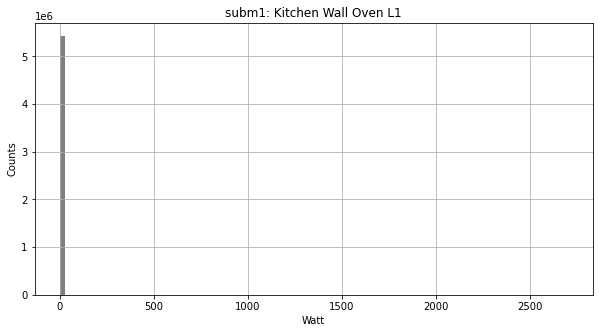

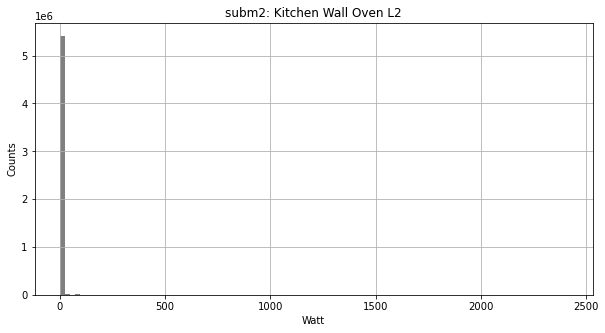

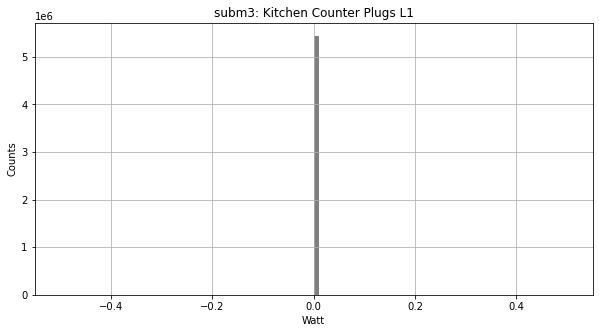

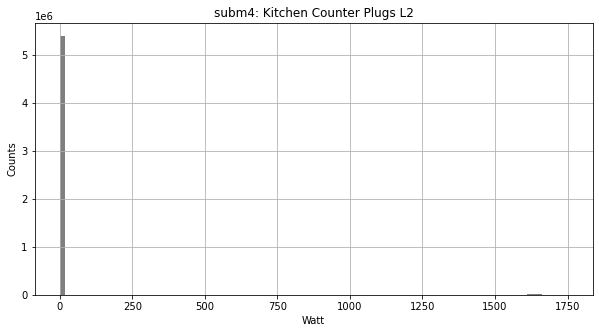

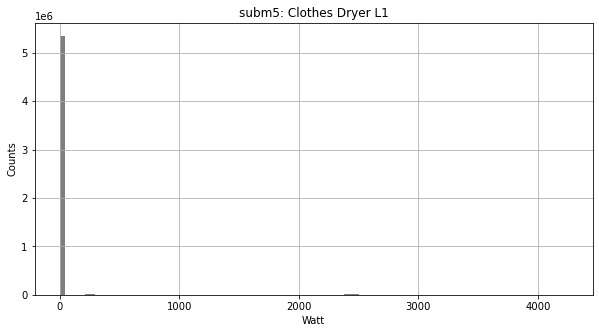

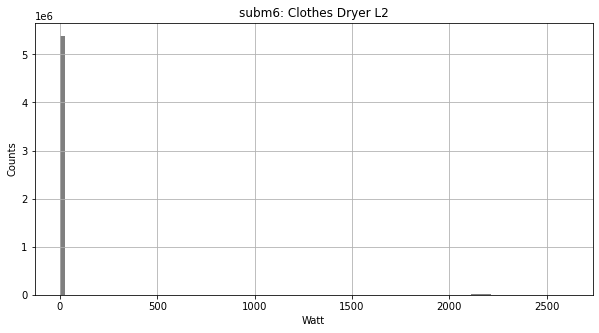

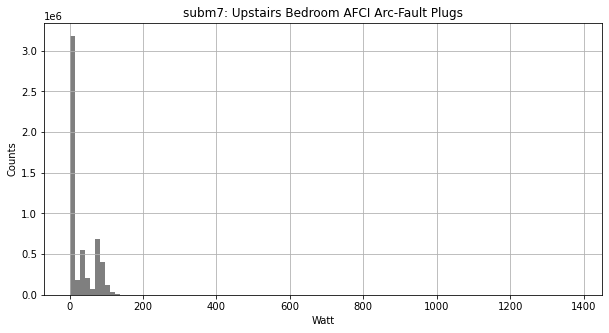

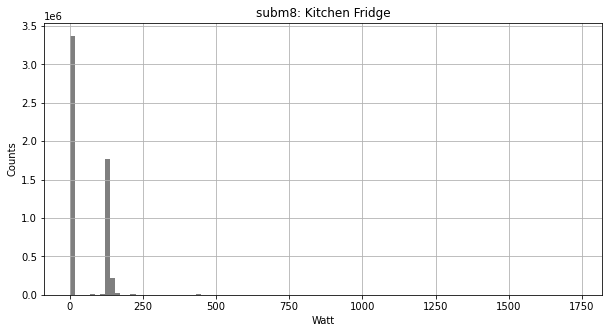

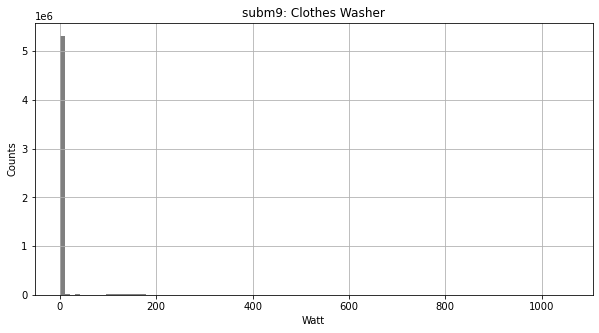

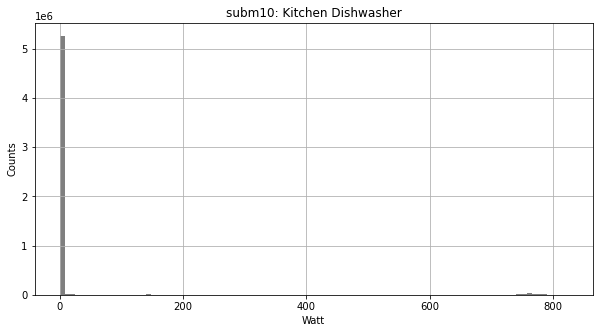

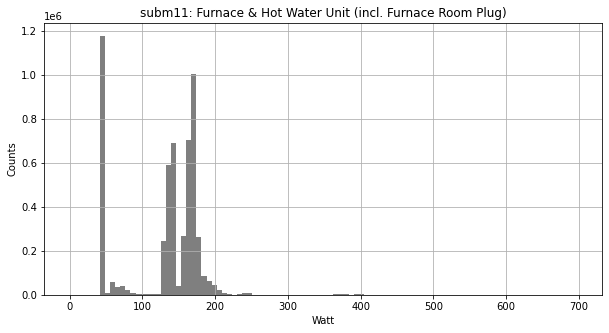

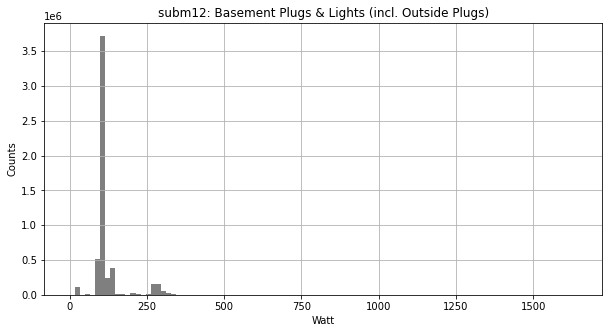

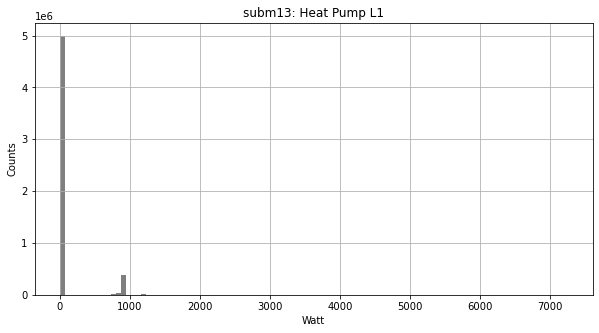

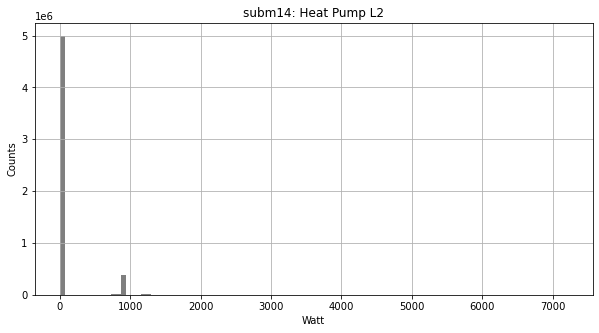

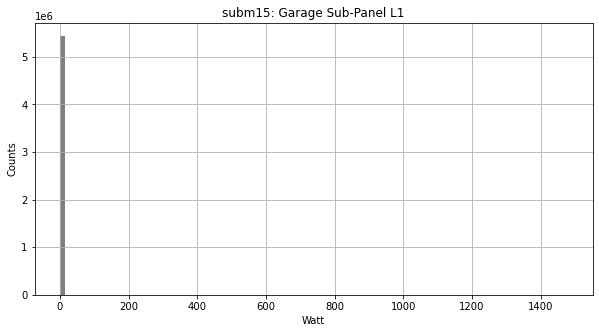

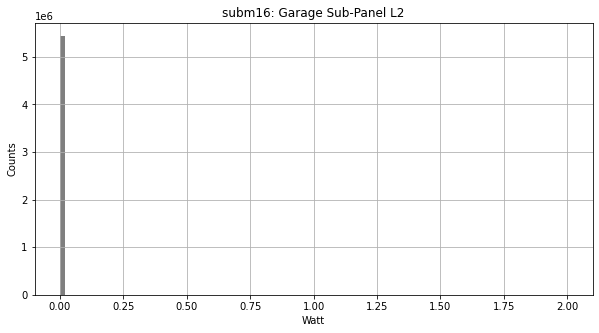

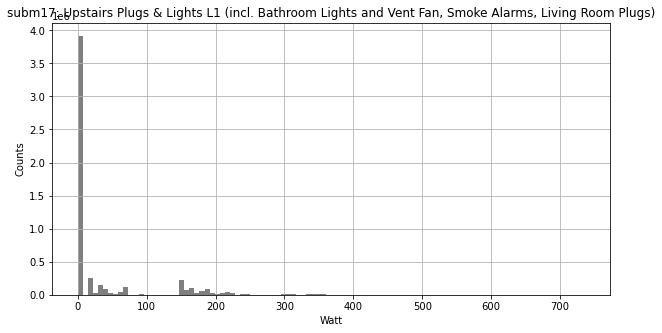

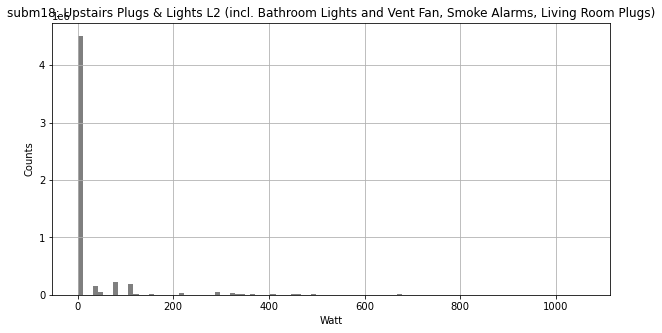

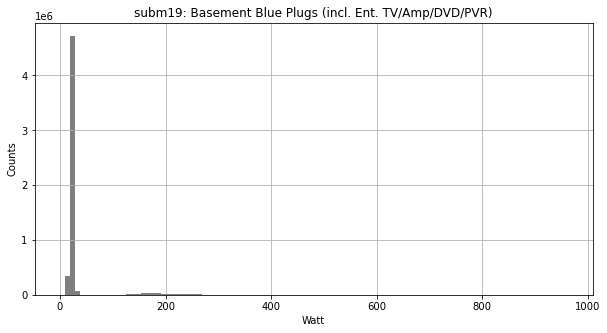

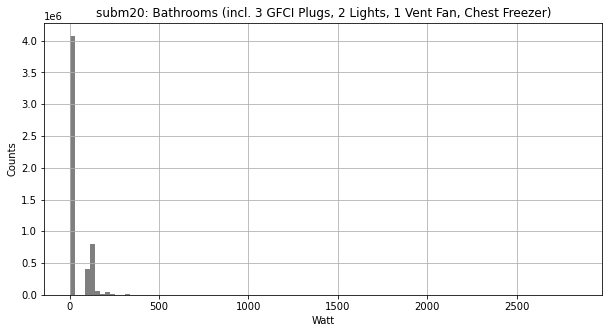

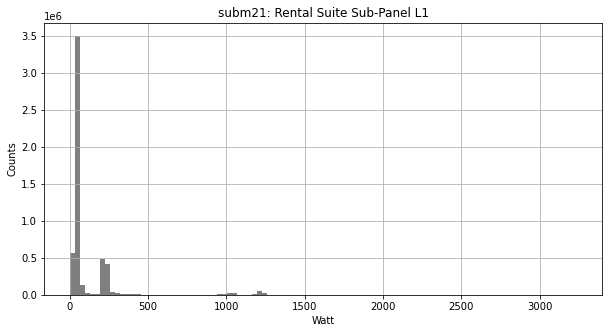

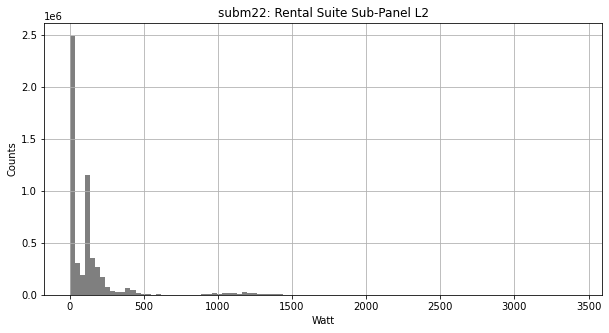

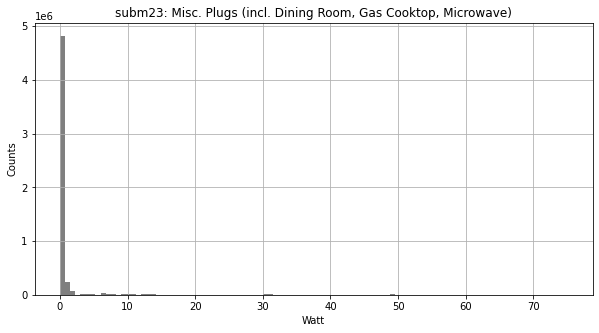

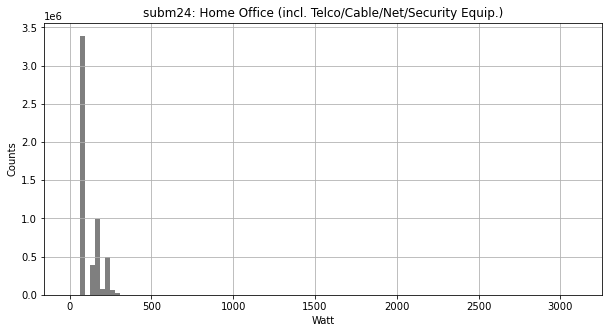

In [82]:
## Check of appliances' power consumption in second sample, covering 63 days:

# Loop over submeters:
for i in range(len(labels_long)):
    
    # Plot histogram for i-th submeter
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(data2[:,3+i], nBins, color="black", alpha=0.5)
    axes.grid()
    axes.set_xlabel("Watt")
    axes.set_ylabel("Counts")
    axes.set_title("subm" + str(i+1) + ": " + labels_long[i])
    plt.show()

In [83]:
## Try to reproduce plot of all loads for one day for house 1, as in [Makonin et al., 2019]:
## Note: stackplot needs transposed data!

# Create time axis for one day:
time = range(24*3600)

# Transpose submeter data, need to skip first three columns:
data1_transp = np.transpose(data1[:,3:])
data2_transp = np.transpose(data2[:,3:])

# Extract first day from first sample (covering 9 days in total):
data1_transp_d1 = data_transp[:,:24*3600]

Text(0, 0.5, 'Power [W]')

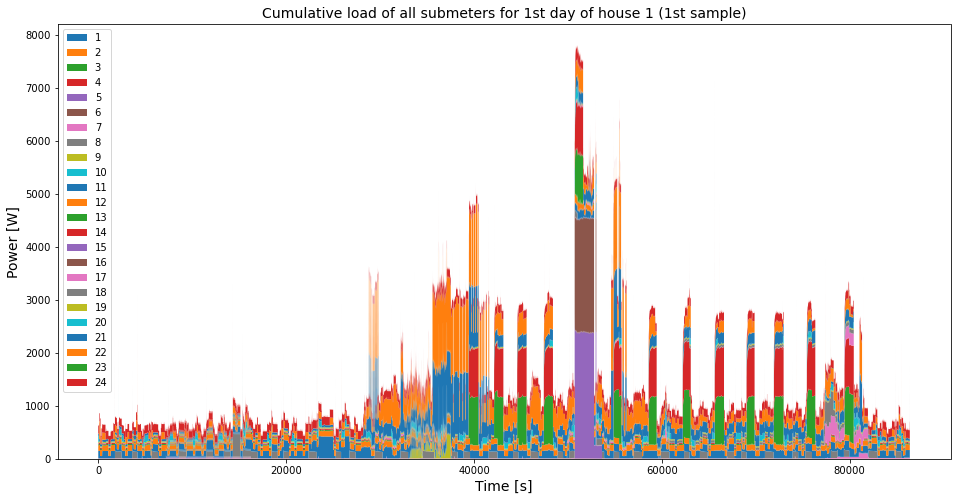

In [84]:
# Plot:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data1_transp_d1, labels=labels_num)
plt.legend(loc='upper left')
plt.title('Cumulative load of all submeters for 1st day of house 1 (1st sample)', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Power [W]', fontsize=14)

In [85]:
## Further aggregate submeters to end up with 10 classes:

# Initialize storage for aggregate transposed submeter data:
data1_transp_agg = np.zeros((10,len(data1)))
data2_transp_agg = np.zeros((10,len(data2)))

## Manually aggragate submeters, as in [Makonin et al. 2019]:

# Garage: Submeters 15, 16
data1_transp_agg[0] = data1_transp[14] + data1_transp[15]
data2_transp_agg[0] = data2_transp[14] + data2_transp[15]

# Clothes Dryer: Submeters 5, 6
data1_transp_agg[1] = data1_transp[4] + data1_transp[5]
data2_transp_agg[1] = data2_transp[4] + data2_transp[5]

# HVAC & Heat Pump: Submeters 11, 13, 14
data1_transp_agg[2] = data1_transp[10] + data1_transp[12] + data1_transp[13]
data2_transp_agg[2] = data2_transp[10] + data2_transp[12] + data2_transp[13]

# Rental Suite: Submeters 21, 22
data1_transp_agg[3] = data1_transp[20] + data1_transp[21]
data2_transp_agg[3] = data2_transp[20] + data2_transp[21]

# Plugs & Lights: Submeters 3, 4, 7, 12, 17, 18, 19, 20, 23
data1_transp_agg[4] = data1_transp[2] + data1_transp[3] + data1_transp[6] + data1_transp[11] + data1_transp[16] + data1_transp[17] + data1_transp[18] + data1_transp[19] + data1_transp[22]
data2_transp_agg[4] = data2_transp[2] + data2_transp[3] + data2_transp[6] + data2_transp[11] + data2_transp[16] + data2_transp[17] + data2_transp[18] + data2_transp[19] + data2_transp[22]

# Wall Oven: Submeters 1, 2
data1_transp_agg[5] = data1_transp[0] + data1_transp[1]
data2_transp_agg[5] = data2_transp[0] + data2_transp[1]

# Fridge: Submeter 8
data1_transp_agg[6] = data1_transp[7]
data2_transp_agg[6] = data2_transp[7]

# Clothes Washer: Submeter 9
data1_transp_agg[7] = data1_transp[8]
data2_transp_agg[7] = data2_transp[8]

# Dish Washer: Submeter 10
data1_transp_agg[8] = data1_transp[9]
data2_transp_agg[8] = data2_transp[9]

# Home Office: Submeter 24
data1_transp_agg[9] = data1_transp[23]
data2_transp_agg[9] = data2_transp[23]

## Create labels for aggregate submeters:
labels_long_agg = ['Garage','Clothes Dryer','HVAC & Heat Pump','Rental Suite','Plugs & Lights','Wall Oven',
                   'Fridge','Clothes Washer','Dish Washer','Home Office']

In [87]:
# Plausibility Check: Sum of aggregated submeters must equal total energy consumption in raw data. 
# Expect zero difference!
print("plausi check sample 1 (expect 0.0): ", np.sum(np.sum(data1_transp_agg,axis=0)-data1[:,2]))
print("plausi check sample 2 (expect 0.0): ", np.sum(np.sum(data2_transp_agg,axis=0)-data2[:,2]))

plausi check sample 1 (expect 0.0):  0.0
plausi check sample 2 (expect 0.0):  0.0


Text(0, 0.5, 'Power [W]')

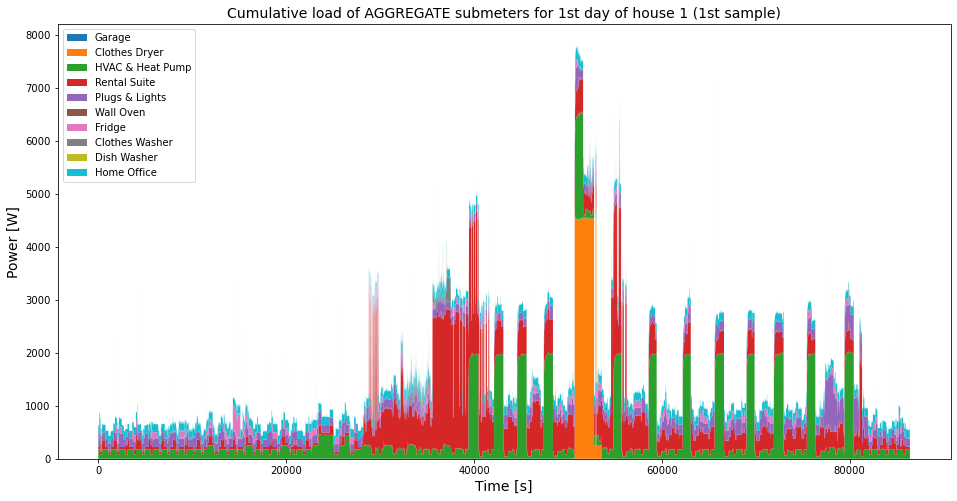

In [88]:
# Plot aggregate submeter data:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data1_transp_agg[:,:24*3600], labels=labels_long_agg)
plt.legend(loc='upper left')
plt.title('Cumulative load of AGGREGATE submeters for 1st day of house 1 (1st sample)', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Power [W]', fontsize=14)

In [90]:
## Inspect 24 submeter signals individually:

# Get mean load for each submeter over whole 63 days in house 1:
mean_load = np.round(np.mean(data2_transp, axis=1),1)

# Get average using time (= nonzero load) in relation to total time span:
avg_usage = np.round(np.sum((data2_transp>0),axis=1) / len(data2),2)

# Print results:
for i in range(len(labels_long)):
    print("submeter",i+1,":",labels_long[i])
    print("mean load [W]: ", mean_load[i])
    print("avg usage [%]: ", avg_usage[i]*100,"\n")

submeter 1 : Kitchen Wall Oven L1
mean load [W]:  2.4
avg usage [%]:  0.0 

submeter 2 : Kitchen Wall Oven L2
mean load [W]:  3.8
avg usage [%]:  99.0 

submeter 3 : Kitchen Counter Plugs L1
mean load [W]:  0.0
avg usage [%]:  0.0 

submeter 4 : Kitchen Counter Plugs L2
mean load [W]:  16.2
avg usage [%]:  100.0 

submeter 5 : Clothes Dryer L1
mean load [W]:  27.4
avg usage [%]:  4.0 

submeter 6 : Clothes Dryer L2
mean load [W]:  23.1
avg usage [%]:  1.0 

submeter 7 : Upstairs Bedroom AFCI Arc-Fault Plugs
mean load [W]:  30.2
avg usage [%]:  100.0 

submeter 8 : Kitchen Fridge
mean load [W]:  52.2
avg usage [%]:  48.0 

submeter 9 : Clothes Washer
mean load [W]:  3.9
avg usage [%]:  6.0 

submeter 10 : Kitchen Dishwasher
mean load [W]:  17.3
avg usage [%]:  6.0 

submeter 11 : Furnace & Hot Water Unit (incl. Furnace Room Plug)
mean load [W]:  132.0
avg usage [%]:  100.0 

submeter 12 : Basement Plugs & Lights (incl. Outside Plugs)
mean load [W]:  121.3
avg usage [%]:  100.0 

submete

In [92]:
## Inspect 10 aggregated submeter signals in sample 2 (covering 63 days) of house 1:

# Get mean load for each submeter over whole 63 days in house 1:
mean_load_agg = np.round(np.mean(data2_transp_agg, axis=1),1)

# Get average using time (= nonzero load) in relation to total time span:
avg_usage_agg = np.round(np.sum((data2_transp_agg>0),axis=1) / len(data2),2)

# Print results:
for i in range(len(labels_long_agg)):
    print("submeter",i+1,"(agg):",labels_long_agg[i])
    print("mean load [W]: ", mean_load_agg[i])
    print("avg usage [%]: ", avg_usage_agg[i]*100,"\n")

submeter 1 (agg): Garage
mean load [W]:  0.1
avg usage [%]:  0.0 

submeter 2 (agg): Clothes Dryer
mean load [W]:  50.5
avg usage [%]:  5.0 

submeter 3 (agg): HVAC & Heat Pump
mean load [W]:  313.2
avg usage [%]:  100.0 

submeter 4 (agg): Rental Suite
mean load [W]:  240.1
avg usage [%]:  100.0 

submeter 5 (agg): Plugs & Lights
mean load [W]:  303.1
avg usage [%]:  100.0 

submeter 6 (agg): Wall Oven
mean load [W]:  6.2
avg usage [%]:  99.0 

submeter 7 (agg): Fridge
mean load [W]:  52.2
avg usage [%]:  48.0 

submeter 8 (agg): Clothes Washer
mean load [W]:  3.9
avg usage [%]:  6.0 

submeter 9 (agg): Dish Washer
mean load [W]:  17.3
avg usage [%]:  6.0 

submeter 10 (agg): Home Office
mean load [W]:  117.5
avg usage [%]:  100.0 



### Disaggregation using CNN network

Inspired by [Kelly, 2017] try to develop some CNN model.

Keep it very simple for the beginning: 

- Start with only few appliances
- Create target values for each appliance as binary value 0/1, if appliance is off/on.

In [ ]:
## Start with submeter 2 (Clothes Dryer, 50.5W mean load and 5% avg usage time) and
##            submeter 7 (Fridge, 52.2W mean load and 48% avg usage time) and 
##            submeter 8 (Clothes Washer, 3.9W mean load and 6% avg usage time) and
##            submeter 9 (Kitchen Dishwasher, 17.3W mean load and 6% avg usage time).

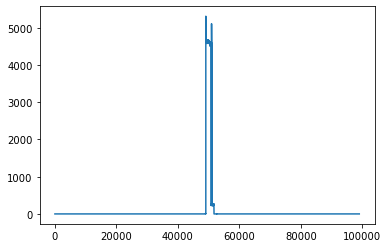

In [120]:
plt.plot(data2_transp_agg[1,1000:100000])

In [121]:
np.sum((data2_transp_agg[1,:]>1))

97559

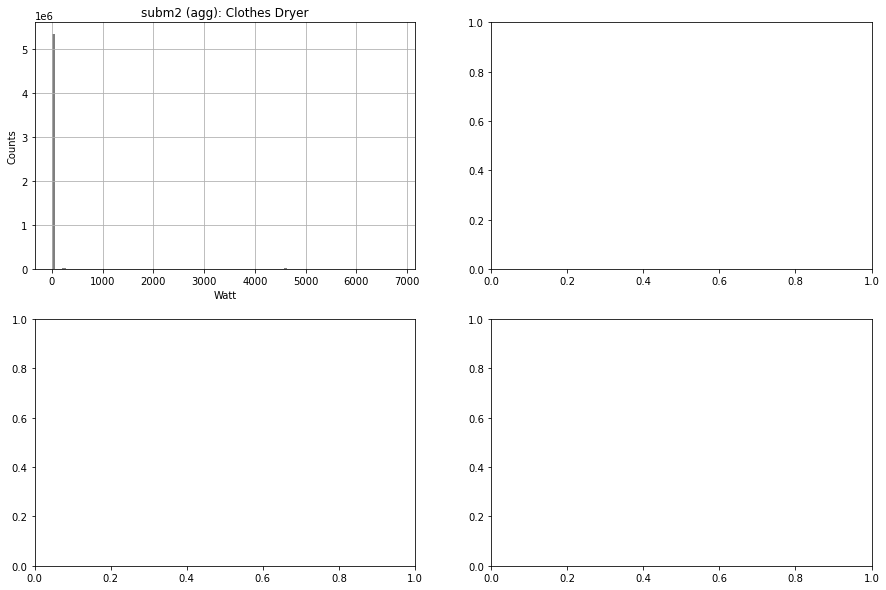

In [115]:
## Check of appliances' power consumption in second sample, covering 63 days:
nBins = 100
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0,0].hist(data2_transp_agg[1,:], nBins, color="black", alpha=0.5)
axes[0,0].grid()
#axes[0,0].set_xlim(xmin=0, xmax=1000)
axes[0,0].set_xlabel("Watt")
axes[0,0].set_ylabel("Counts")
axes[0,0].set_title("subm" + str(2) + " (agg): " + labels_long_agg[1])
plt.show()

In [11]:


# Concatenate submeters 8 and 10:
data_transp_8_10 = np.concatenate([data_transp[7:8], data_transp[9:10]])

# Create binary target: Appliance on/off as 1/0, swap axes to have dimension (samples, features):
target_bin = np.swapaxes((data_transp_8_10 != 0).astype(int), 0, 1)

# Get total load of these two appliances, used as input:
input_8_10 = np.sum(data_transp_8_10, axis=0)

# Check dimensions:
print("input dimension: ", input_8_10.shape)
print("bin. target dimension: ", target_bin.shape)

input dimension:  (777600,)
bin. target dimension:  (777600, 2)


Text(0, 0.5, 'Power [W]')

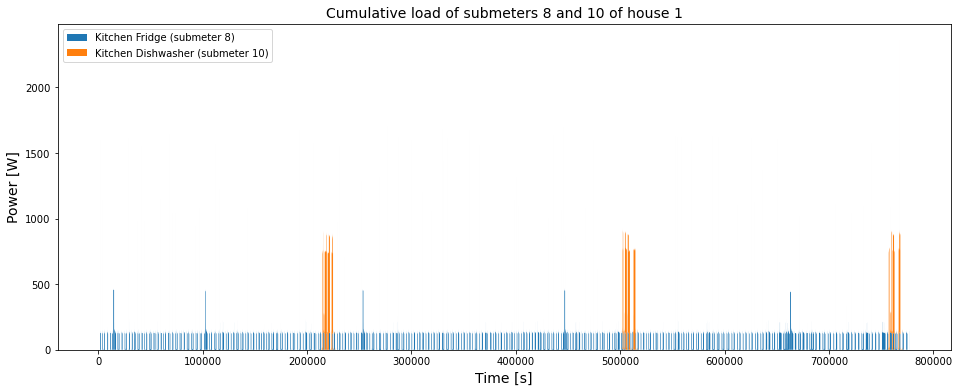

In [12]:
# Plot aggregate submeter data for submeters 8 and 10:
fig, ax = plt.subplots(figsize=(16, 6))
ax.stackplot(range(len(data)), data_transp_8_10, labels=['Kitchen Fridge (submeter 8)', 'Kitchen Dishwasher (submeter 10)'])
plt.legend(loc='upper left')
plt.title('Cumulative load of submeters 8 and 10 of house 1', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Power [W]', fontsize=14)

In [54]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

# Specify input length:
input_length = 60

# Split input values into sequences of specified length:
input_8_10_split = split_sequence(input_8_10, input_length)

# Reshape inputs to have third dimension (num features):
input_8_10_split = np.reshape(input_8_10_split, (input_8_10_split.shape[0], input_8_10_split.shape[1], 1))

# Split binary targets into sequences of the same length:
target_bin_split = split_sequence(target_bin, input_length)

# Then adjust targets: If appliance is ON for at least ONE second within 60 sec intervall, then set target = 1
targets = np.max(target_bin_split, axis=1)

# Dimension check:
print("input dimension (samples, time steps): ", np.shape(input_8_10_split))
print("target dimension (samples, time steps, features): ", np.shape(targets))

input dimension (samples, time steps):  (777541, 60, 1)
target dimension (samples, time steps, features):  (777541, 2)


In [55]:
## Scale inputs to [0,1] using min-max-scaling: Substract min and divide by (max - min)

# Get min and max on WHOLE input series:
input_max = np.max(input_8_10_split)
input_min = np.min(input_8_10_split)

# Scale:
inputs = (input_8_10_split - input_min) / (input_max - input_min)

## Split inputs and targets into train and validation sets:

# Get number of train samples: 80% of ALL samples
n_train = int(0.8 * len(inputs))

# Split:
train_input = inputs[:n_train]
val_input = inputs[n_train:]
train_target = targets[:n_train]
val_target = targets[n_train:]

## Dimension check:
print("train inputs (samples, time steps): ", train_input.shape)
print("val inputs (samples, time steps): ", val_input.shape)
print("\ntrain targets (samples, time steps, features): ", train_target.shape)
print("val targets (samples, time steps, features): ", val_target.shape)

train inputs (samples, time steps):  (622032, 60, 1)
val inputs (samples, time steps):  (155509, 60, 1)

train targets (samples, time steps, features):  (622032, 2)
val targets (samples, time steps, features):  (155509, 2)


In [97]:
## Set up simple CNN model
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=(input_length, 1), strides=1))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=8, strides=1))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(units=20, activation = 'linear'))
model.add(Dense(units=2, activation = 'sigmoid'))

# Get model summary:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 54, 10)            80        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 54, 10)            0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 27, 10)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 20, 20)            1620      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 20, 20)            0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 10, 20)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)             

In [98]:
# Compile model:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['acc'])

# Train model:
history = model.fit(train_input, train_target, epochs=3, batch_size=100, verbose=1, validation_data=(val_input, val_target))

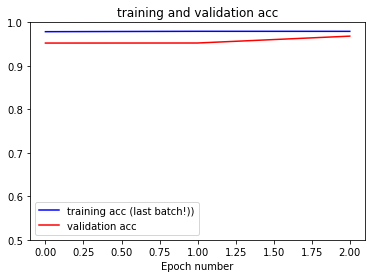

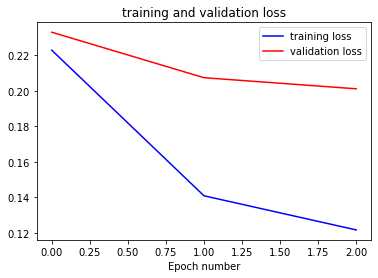

In [79]:
# plot train and val_acc 
plt.plot(history.history['acc'], color = 'blue', label = 'training acc (last batch!))')
plt.plot(history.history['val_acc'], color = 'red', label = 'validation acc')
plt.xlabel('Epoch number')
plt.ylim(0.5, 1)
plt.title('training and validation acc')
plt.legend()
plt.show()

# plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('training and validation loss')
plt.legend()
plt.show()  

In [99]:
## Get model predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

In [100]:
## Convert to binary predictions:
train_pred_bin = (train_pred > 0.5).astype(int)
val_pred_bin = (val_pred > 0.5).astype(int)

In [101]:
## For comparision: Accuracy of UNTRAINED model:

train_acc [subm1, subm2]:  [94.83 58.24]
val_acc [subm1, subm2]:  [94.38 55.31]


In [96]:
## Calculate accuracy on train and validation data manually:
train_acc = np.sum((train_pred_bin==train_target), axis=0) / len(train_target)
val_acc = np.sum((val_pred_bin==val_target), axis=0) / len(val_target)

# Check accuracy:
print("train_acc [subm1, subm2]: ", np.round(train_acc*100, 2))
print("val_acc [subm1, subm2]: ", np.round(val_acc*100, 2))

train_acc [subm1, subm2]:  [96.45 97.13]
val_acc [subm1, subm2]:  [96.5  93.25]


In [ ]:
# Keep in mind: Fridge shows spike load when switching on in first second!

# NEXT:
# Does that work?
# Increase number of appliances!
# Try to predict switching events!
# ...

# Then try (bi-directional) LSTM model